<a href="https://colab.research.google.com/github/golphy-yy/DeepLearning-Project/blob/main/Project_Predicting_The_Efficiency_of_A_Heat_Exchanger_Over_Time_Using_LSTM_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### DATA IMPORTING

In [1]:
# prompt: mount google drive

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('HEXeff_dataWeekly.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)
df = df[['Efficiency (%)']]
df.head()

##### DATA VISUALIZATION

<Axes: xlabel='Date', ylabel='Efficiency (%)'>

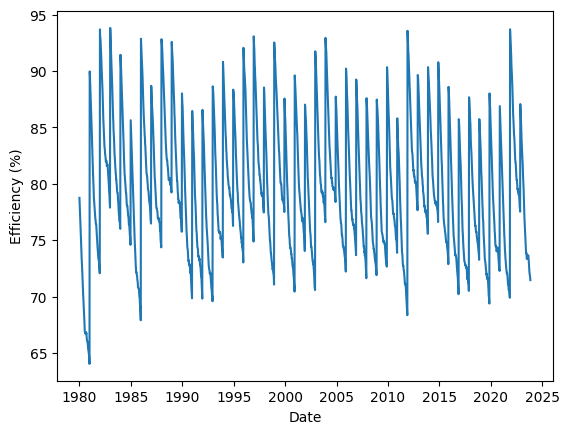

In [24]:

sns.lineplot(y=df["Efficiency (%)"],x = df.index,data = df)

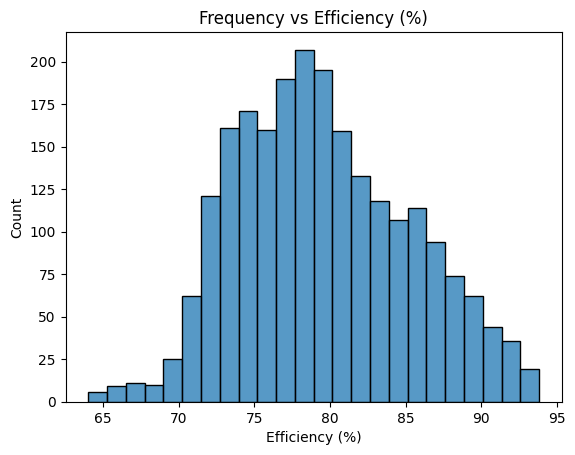

In [19]:

sns.histplot(df["Efficiency (%)"])
plt.title("Frequency vs Efficiency (%)")
plt.show()

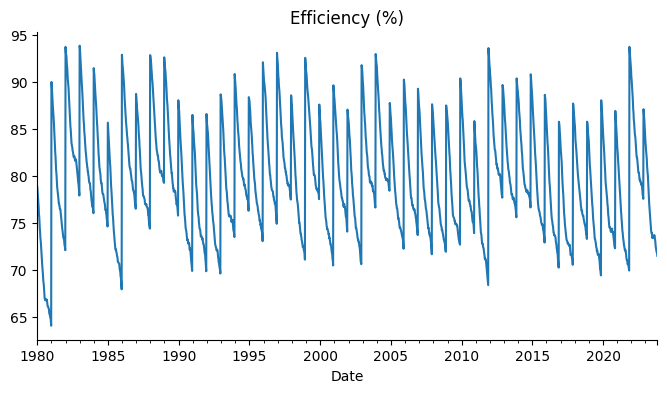

In [5]:
# @title Efficiency (%)

from matplotlib import pyplot as plt
df['Efficiency (%)'].plot(kind='line', figsize=(8, 4), title='Efficiency (%)')
plt.gca().spines[['top', 'right']].set_visible(False)

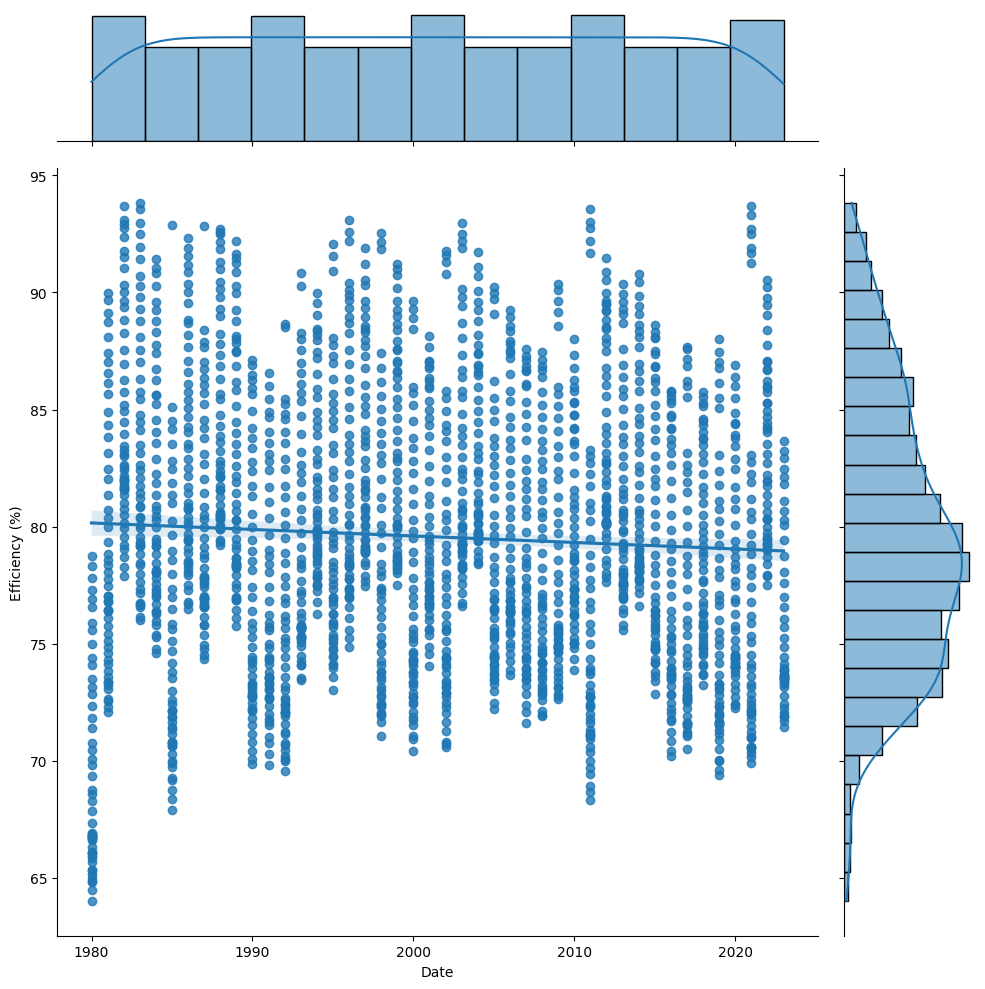

In [39]:
import datetime as dt
sns.jointplot(x=df.index.year,
              y=df["Efficiency (%)"],
              data=df,
              kind="reg",
              height=10
             )

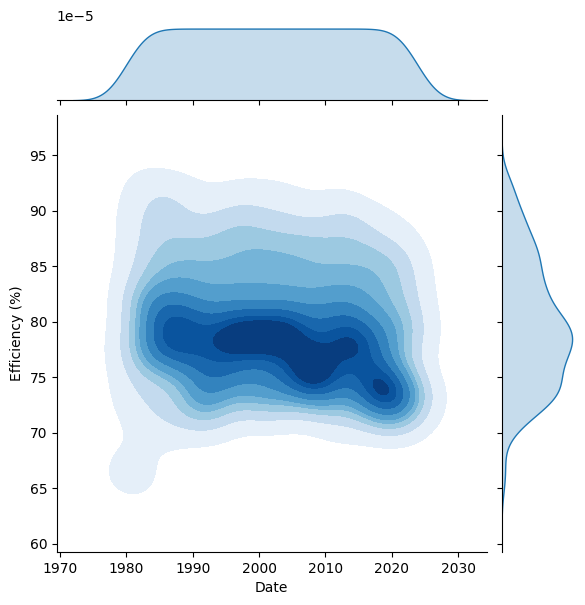

In [44]:
sns.jointplot(x=df.index,
              y=df["Efficiency (%)"],
              data=df,
              kind="kde",
              cmap = 'Blues',
              fill = True
             )

##### DATA PREPROCESSING BEFORE TRAINING MODEL

In [9]:
print(df.shape)
uni_data = df.values.flatten()

(2288, 1)


In [120]:
### fucntion to create time steps
def create_time_steps(length):
  return list(range(-length,0))
### function to plot time series data

def plot_time_series(plot_data, delta , title):
  labels = ["History" , 'True Future' , 'Model Predicted']
  marker = ['.-' , 'rx' , 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])

  if delta:
    future = delta
  else:
    future = 0
  plt.title(title)
  for i , x in enumerate(plot_data): # INPUT NO. ตัวแรกเป็นข้อมูลหลัก ตัวถัดๆมาเป็นแค่ตัวรอง
    if i : # if i != 0
      print(i)
      plt.plot(future , plot_data[i] , marker[i], markersize = 10 , label = labels[i])
    else:
      print(i)
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label = labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5) *2])

  plt.xlabel('Time_Step')
  return plt

In [46]:
### Moving window average

def MWA(history):
  return np.mean(history)

In [81]:
train_split = 1800

In [82]:
val_split = 200

In [83]:
features = df
dataset = features.values

data_mean = dataset[:train_split].mean(axis =0)
print(data_mean)
data_std = dataset[:train_split].std(axis = 0)
print(data_std)
dataset = (dataset - data_mean)/data_std

[79.93468813]
[5.77591842]


In [84]:
### create mutlivariate data

def multivariate_data(dataset , target , start_idx , end_idx , history_size , target_size,
                      step ,  single_step = False):
  data = []
  labels = []
  start_idx = start_idx + history_size
  if end_idx is None:
    end_idx = len(dataset)- target_size
  for i in range(start_idx , end_idx ):
    idxs = range(i-history_size, i, step) ### using step  การข้ามช่วง ex  data range(0,21) range(6,27) range(12, 33)
    data.append(dataset[idxs])
    if single_step: # != 0 false or None
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data) , np.array(labels)

In [85]:
history = 156

STEP = 1
future_target = 72# 72 future values
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 0], 0,
                                                 train_split, history,
                                                 future_target, STEP)

x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 0],
                                             train_split, train_split+val_split, history,
                                             future_target, STEP)

x_test_multi, y_test_multi = multivariate_data(dataset, dataset[:, 0],
                                               train_split+val_split, None,
                                               history,
                                               future_target, STEP)



print(x_train_multi.shape)
print(y_train_multi.shape)

print(x_val_multi.shape)
print(y_val_multi.shape)


print(x_test_multi.shape)
print(y_test_multi.shape)

(1644, 156, 1)
(1644, 72)
(44, 156, 1)
(44, 72)
(60, 156, 1)
(60, 72)


In [86]:
def plot_loss(history , title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))
  plt.figure()
  plt.plot(epochs, loss , 'b' , label = 'Train Loss')
  plt.plot(epochs, val_loss , 'r' , label = 'Validation Loss')
  plt.title(title)
  plt.legend()
  plt.grid()
  plt.show()

##### LSTM MODEL

In [87]:
import tensorflow as tf
# TF DATASET
batch_size = 256
buffer_size = 700 #10000
steps = 200
EPOCHS =100

# สร้าง Dataset จากข้อมูล x_train_multi และ y_train_multi
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(buffer_size).batch(batch_size).repeat()

# สร้าง Dataset สำหรับ validation
val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(batch_size).repeat()

# สร้าง Dataset สำหรับ test set
test_data_multi = tf.data.Dataset.from_tensor_slices((x_test_multi, y_test_multi))
test_data_multi = test_data_multi.batch(batch_size)

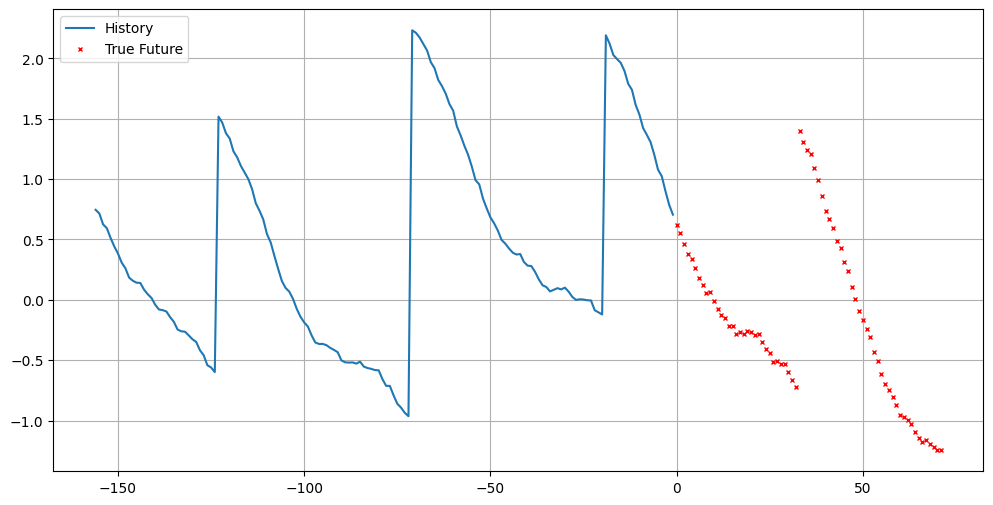

In [88]:
#plotting function
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)
  plt.grid()
  plt.plot(num_in, np.array(history[:, 0]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'rx',markersize=3,
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction),'go',markersize=5,
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()



for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [89]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from keras.layers import InputLayer, LSTM, Dense, Conv1D, MaxPooling1D, Flatten, Dropout

In [90]:
# สร้างโฟลเดอร์เพื่อเก็บโมเดล
import os
os.makedirs('model_checkpoint', exist_ok=True)
cp = ModelCheckpoint('model_checkpoint/bestmodelWeekly.keras',save_best_only=True)

In [91]:
from tensorflow.keras import layers, models, optimizers , callbacks


multi_step_model = models.Sequential()
multi_step_model.add(layers.LSTM(32,
                                 return_sequences=True,
                                 input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(layers.LSTM(16, activation='relu'))
multi_step_model.add(layers.Dense(72)) # for 72 outputs
multi_step_model.compile(optimizer=optimizers.RMSprop(clipvalue=1.0), loss='mae')
# สร้าง EarlyStopping callback เพื่อหยุดการฝึกเมื่อไม่มีการปรับปรุง
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [92]:
EPOCHS = 20
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=steps,
                                          validation_data=val_data_multi,
                                          validation_steps=50,callbacks=[cp])

Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 49s 231ms/step - loss: 0.7032 - val_loss: 0.4125
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 46s 232ms/step - loss: 0.4799 - val_loss: 0.4161
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 45s 226ms/step - loss: 0.4212 - val_loss: 0.3714
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 45s 227ms/step - loss: 0.3918 - val_loss: 0.3775
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 46s 228ms/step - loss: 0.3737 - val_loss: 0.4069
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 46s 228ms/step - loss: 0.3594 - val_loss: 0.3414
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 46s 230ms/step - loss: 0.3391 - val_loss: 0.3130
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 46s 229ms/step - loss: 0.3225 - val_loss: 0.2986
Epoch 9/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 46s 229ms/step - loss: 0.3109 - val_loss: 0.2988
Epoch 10/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 48s 239ms/step - loss: 0.3024 - val_loss: 0.2881
Epoch 11/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 46s 230ms/step - loss: 0.2946 - val_loss: 0.3002
Epoch 12/20
200/200

In [93]:
multi_step_model.save('model_checkpoint/test_modelWeekly.keras')
  #ตรวจสอบไฟล์ที่บันทึกในโฟลเดอร์
files = os.listdir('model_checkpoint')
print("Files in model_checkpoint directory:", files)

Files in model_checkpoint directory: ['test_model.keras', 'bestmodel.keras', 'test_model2.keras', 'bestmodelWeekly.keras', 'test_modelWeekly.keras']


##### MODEL EVALUATION

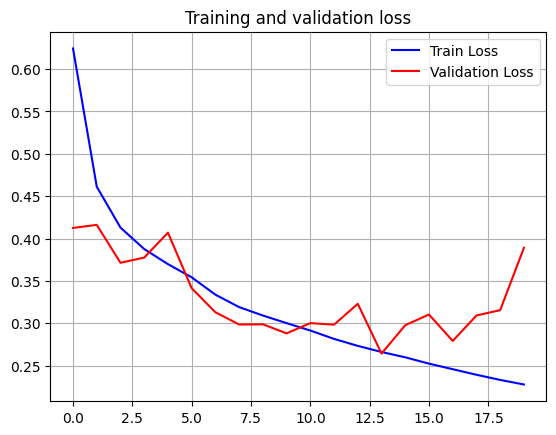

In [94]:
plot_loss(multi_step_history, 'Training and validation loss')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


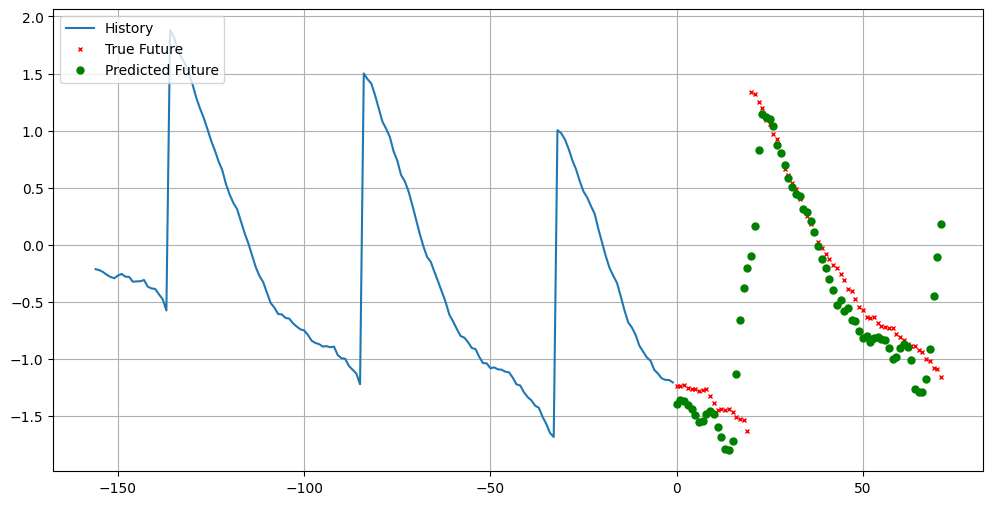

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


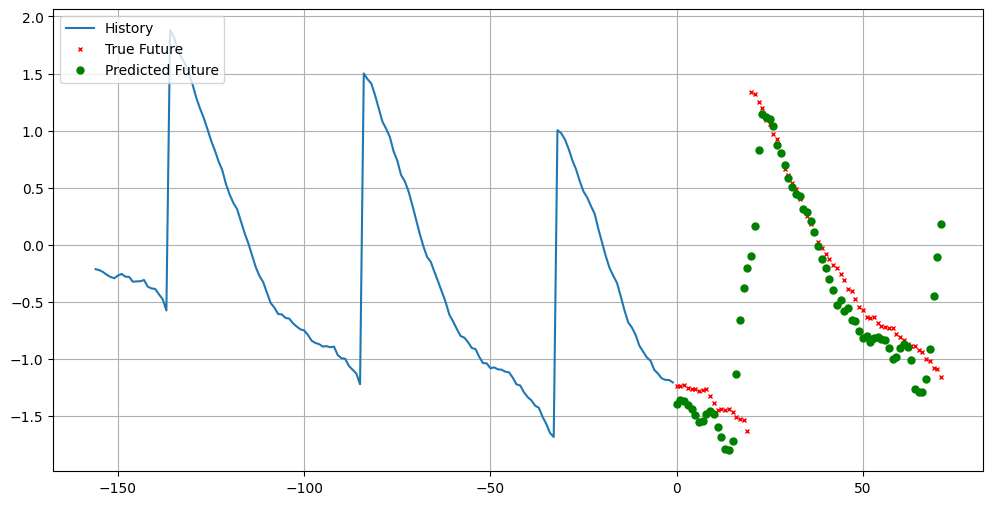

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


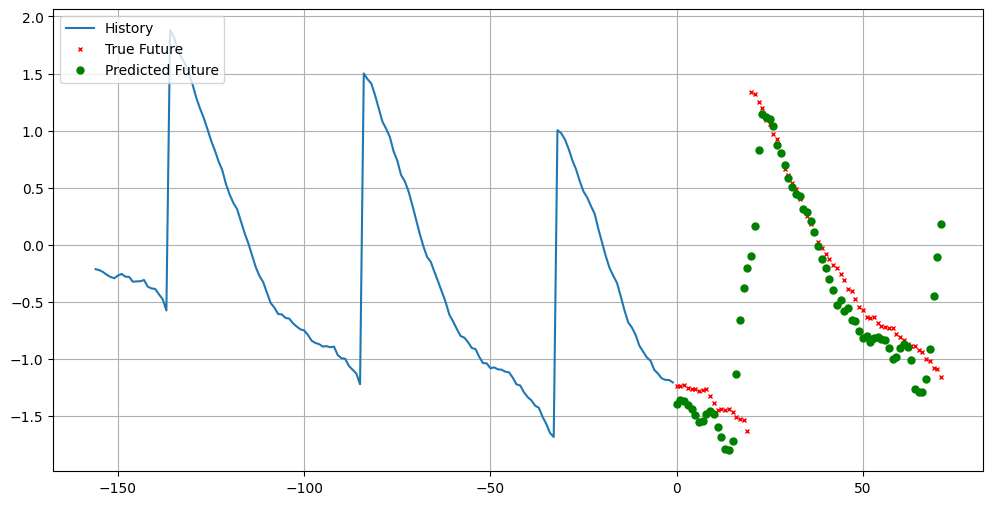

In [101]:
#CHECK WITH VALSET
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


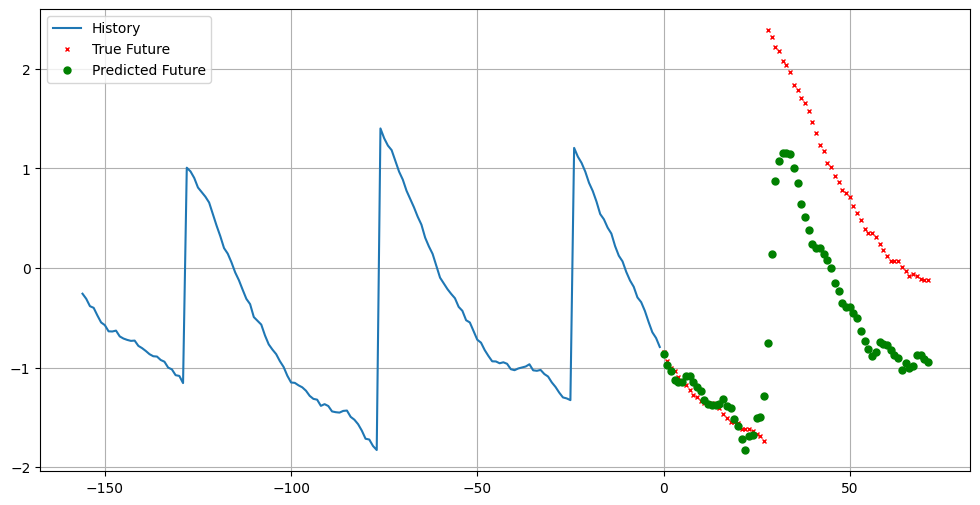

In [100]:
#CHECK WITH TESTSET
for x, y in test_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

In [95]:
# ประเมินโมเดลด้วยข้อมูลทดสอบหลังจากการฝึก
test_loss = multi_step_model.evaluate(test_data_multi)
print(f'Test Loss: {test_loss}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.4890
Test Loss: 0.4890139400959015


In [97]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ทำนายผลลัพธ์จากข้อมูลทดสอบ
predictions = multi_step_model.predict(x)[0]

# คำนวณ MAE
mae = mean_absolute_error(y_test_multi, predictions)
print(f'Mean Absolute Error (MAE): {mae}')

# คำนวณ MSE
mse = mean_squared_error(y_test_multi, predictions)
print(f'Mean Squared Error (MSE): {mse}')

# คำนวณ RMSE
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# คำนวณ R²
r_squared = r2_score(y_test_multi, predictions)
print(f'R²: {r_squared}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Mean Absolute Error (MAE): 0.4890139067185097
Mean Squared Error (MSE): 0.44960131329989966
Root Mean Squared Error (RMSE): 0.6705231638801896
R²: 0.002111039285828689


##### MODEL PREDICTION

In [127]:
### standardize data
uni_data = df.values.flatten()
uni_data_mean = uni_data[:train_split].mean()
print(uni_data_mean)
uni_data_std = uni_data[:train_split].std()
print(uni_data_std)
uni_data  = (uni_data - uni_data_mean)/ uni_data_std

uni_data[-156:].shape
datax = uni_data[-156:]  # ข้อมูลต้นฉบับที่มี shape (156,)

# ปรับให้เป็น shape (1, 120, 1)
new_data = np.reshape(datax, (1, 156, 1))


79.93468812653556
5.77591842243577


In [147]:
def multi_step_plot2(history, true_future, prediction, title='Efficiency Prediction'):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.grid(True, linestyle='--', alpha=0.7)

    # Plot History
    plt.plot(num_in, np.array(history[:, 0]), 'b-', markersize=10, label='History', linewidth=2)

    # Plot Predicted Future
    if prediction.any():
        plt.plot(np.arange(num_out), np.array(prediction), 'rx', markersize=7, label='Predicted Future', linewidth=2)

    # Plot True Future
    #plt.plot(np.arange(num_out), true_future, 'g--', markersize=5, label='True Future', linewidth=2)

    # Labeling
    plt.title(title, fontsize=16)
    plt.xlabel('Time Step', fontsize=14)
    plt.ylabel('Efficiency', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Legend
    plt.legend(loc='upper left', fontsize=12)

    # Annotation for Time Step explanation
    plt.text(0.5, 0.9, '1 Time Step = 1 Week', ha='center', va='center', transform=plt.gca().transAxes,
             fontsize=12, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

    # Customize the background
    plt.gca().set_facecolor('lightgrey')
    plt.grid(True)

    plt.tight_layout()  # Adjust layout to prevent clipping
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


<Figure size 1000x600 with 0 Axes>

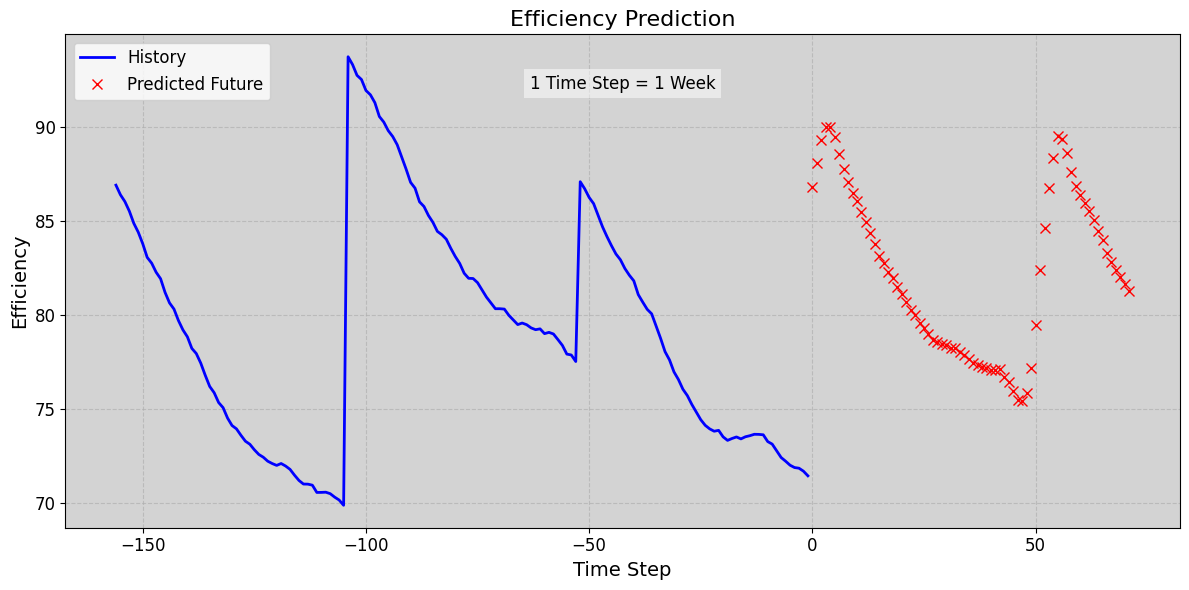

In [148]:

import numpy as np

# ข้อมูลใหม่ (ตัวอย่างเช่น ข้อมูล sequence ขนาด 120 timestep)
# ต้องมี shape (1, 120, 1) เนื่องจากโมเดลคาดหวังข้อมูลขนาดนี้
  # แทนข้อมูลปัจจุบันของคุณที่ต้องการทำนาย
#print(new_data)
# ทำนายข้อมูลใหม่
predicted_output = multi_step_model.predict(new_data)
# ทำให้มิติของ predicted_output เป็น (72,) แทนที่จะเป็น (1, 72)
predicted_output = np.squeeze(predicted_output)
# ดูผลลัพธ์การทำนาย
#print("Predicted Output:", predicted_output)

# Plot ข้อมูลใหม่เทียบกับผลลัพธ์ที่ทำนาย
plt.figure(figsize=(10, 6))

# สมมติว่าข้อมูลใหม่ที่คุณต้องการเปรียบเทียบคือ new_data[0]
multi_step_plot2((new_data[0]*uni_data_std + uni_data_mean ),np.zeros((72,)), (predicted_output*uni_data_std + uni_data_mean ))
plt.show()


##### LOAD MODEL

In [ ]:
from tensorflow.keras.models import load_model
%cd /content/drive/MyDrive/
multi_step_model = load_model('/content/drive/MyDrive/model_checkpoint/test_modelWeekly.keras')